# Predict volume from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')

preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [4]:
preprocessor.train_val_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,v_lp,myear,filename_1,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,0
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,0
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,0
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,0
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,0


In [56]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col=['v'], path=data_path/'AV_las',
                                                     mask_plot=True,
                                                     min_h=1.5,
                                                     normalize=True,
                                                     log_y=False)

100%|██████████| 225/225 [00:11<00:00, 19.83it/s]


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [57]:
dls = trainval_tb.dataloaders(bs=64, y_block=CategoryBlock)

Check the distribution of the target variable `v`, in order to get limits for `sigmoid_range`.

In [58]:
trainval_tb.train.y.describe()

count    1044.000000
mean      145.712250
std        86.097336
min         2.700000
25%        80.927498
50%       132.125000
75%       191.305000
max       867.349976
Name: v, dtype: float64

In [59]:
trainval_tb.valid.y.describe()

count    225.000000
mean     150.768631
std       95.610825
min        2.310000
25%       87.419998
50%      133.600006
75%      191.639999
max      539.479980
Name: v, dtype: float64

In [60]:
test_tb.train.y.describe()

count    225.000000
mean     152.013641
std       97.223846
min        7.000000
25%       87.820000
50%      134.979996
75%      192.529999
max      550.169983
Name: v, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 1000 m³ as the maximum value for the total volume.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [61]:
learn = tabular_learner(dls, 
                        metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  
                        y_range=(0,trainval_tb.train.y.max()*1.1)
                       )
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 69'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 69              138        True      
________________________________________________________________
BatchNorm1d          64 x 69              138        True      
________________________________________________________________
Linear               64 x 200             13,800     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

Find learning rate to use.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.001737800776027143)

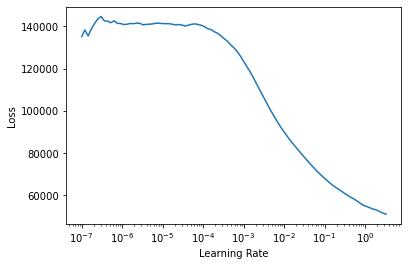

In [62]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,131436.359375,115753.328125,340.225403,225.660614,329.304901,218.417374,329.304932,-11.719026,00:00
1,106504.140625,60226.523438,245.410919,162.773193,227.559402,150.932846,230.960556,-5.617716,00:00
2,73356.593750,13365.247070,115.608162,76.679192,73.834587,48.972115,97.297478,-0.468579,00:00
3,47743.046875,3705.306396,60.871231,40.373936,19.759701,13.105976,44.334774,0.592859,00:00
4,32100.849609,3341.374268,57.804623,38.339954,13.181461,8.742841,37.815723,0.632848,00:00
5,22398.689453,2343.814941,48.412964,32.110767,10.518738,6.976742,32.536076,0.742461,00:00
6,16028.430664,1885.990723,43.427994,28.804398,1.366477,0.906340,30.550694,0.792767,00:00
7,11678.176758,1790.597778,42.315456,28.066486,-1.744778,-1.157256,29.307455,0.803248,00:00
8,8736.951172,1603.711792,40.046371,26.561474,-0.759433,-0.503707,27.537964,0.823783,00:00
9,6621.859863,1990.269165,44.612434,29.589998,-5.317047,-3.526627,29.392593,0.781308,00:00


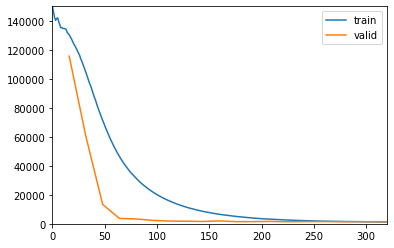

In [63]:
learn.fit_one_cycle(20, max_lr=1e-3, cbs=ShowGraphCallback())

See validation results

In [64]:
learn.validate()

(#7) [1474.400390625,38.397926330566406,25.468114852905273,7.950533866882324,5.273334503173828,25.582548141479492,0.8379922422986047]

In [65]:
preds, true = learn.get_preds()

`RegressionInterpretation` can be used to plot results.

In [66]:
preds.shape

torch.Size([225, 1])

In [67]:
reg_interp = RegressionInterpretation.from_learner(learn, dl=learn.dls[1])

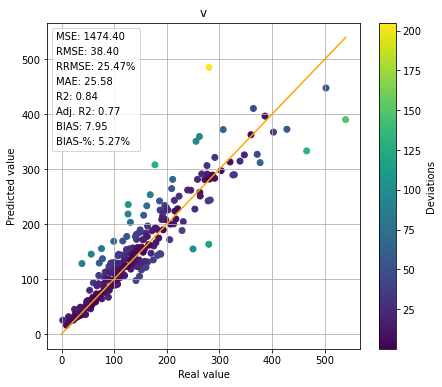

In [68]:
reg_interp.plot_results(log_y=False)
plt.show()

Evaluate test set.

In [69]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [70]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

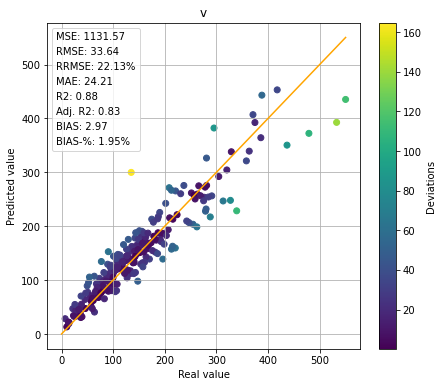

In [71]:
test_interp.plot_results(log_y=False)
plt.show()

# Ensemble of ANNs

Fit several models at once.

In [72]:
ensemble = Ensemble(dls, learn_func=tabular_learner, ens_dir='ensemble_test',
                    y_range=(0,trainval_tb.y.max() * 1.1), 
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], 
                    n_models=10)

In [ ]:
ensemble.fit_one_cycle(20, 1e-2)

In [74]:
res = ensemble.validate()

See ensemble validation results.

In [75]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,35.775391,23.728670,7.928883,5.258974,23.959759,0.859366
1,0,37.675598,24.989016,7.047666,4.674491,25.796368,0.844030
2,1,35.504856,23.549232,7.388771,4.900735,24.585543,0.861485
3,2,38.067406,25.248892,7.865815,5.217143,25.087566,0.840769
4,3,37.167988,24.652334,7.852654,5.208414,24.593073,0.848205
5,4,39.577179,26.250273,9.104361,6.038630,26.079910,0.827888
6,5,38.752903,25.703558,4.426836,2.936179,25.550562,0.834983
7,6,38.233433,25.359011,8.565824,5.681436,27.089151,0.839377
8,7,38.256302,25.374180,11.232385,7.450081,25.721788,0.839185
9,8,39.070862,25.914452,8.918388,5.915281,25.784670,0.832264


In [76]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

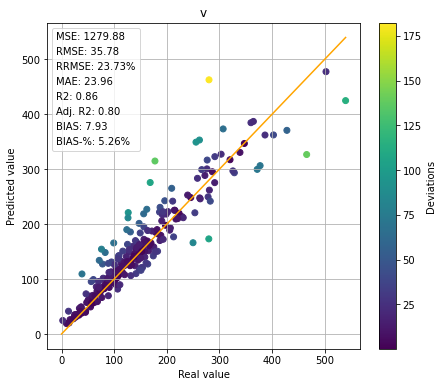

In [77]:
ens_int.plot_results(log_y=False)
plt.show()

Run test set predictions.

In [78]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,32.936722,21.666952,2.034754,1.338534,22.127066,0.884721
1,0,35.203999,23.158447,1.704242,1.121112,23.727951,0.868304
2,1,36.015362,23.692190,1.023700,0.673426,23.136518,0.862163
3,2,34.259064,22.536835,2.834677,1.864752,23.780184,0.875279
4,3,36.170177,23.794035,3.144439,2.068524,24.799242,0.860976
5,4,35.410412,23.294233,2.315593,1.523279,24.522430,0.866755
6,5,34.617981,22.772943,-1.121998,-0.738090,23.449156,0.872652
7,6,34.764641,22.869421,3.567236,2.346655,23.818312,0.871571
8,7,33.328377,21.924595,4.125789,2.714091,23.376888,0.881963
9,8,37.048294,24.371691,2.787756,1.833886,25.119408,0.854144


In [79]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

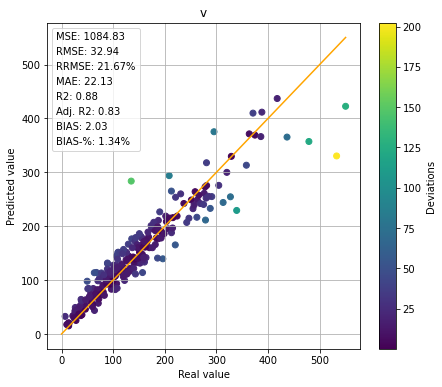

In [80]:
test_ens_interp.plot_results(log_y=False)
plt.show()

In [81]:
ensemble.export()

In [82]:
loaded_ens = load_ensemble('ensemble')

In [83]:
loaded_ens.validate(dls[1])

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,35.775391,23.728670,7.928883,5.258974,23.959759,0.859366
1,0,37.675598,24.989016,7.047666,4.674491,25.796368,0.844030
2,1,35.504856,23.549232,7.388771,4.900735,24.585543,0.861485
3,2,38.067406,25.248892,7.865815,5.217143,25.087566,0.840769
4,3,37.167988,24.652334,7.852654,5.208414,24.593073,0.848205
5,4,39.577179,26.250273,9.104361,6.038630,26.079910,0.827888
6,5,38.752903,25.703558,4.426836,2.936179,25.550562,0.834983
7,6,38.233433,25.359011,8.565824,5.681436,27.089151,0.839377
8,7,38.256302,25.374180,11.232385,7.450081,25.721788,0.839185
9,8,39.070862,25.914452,8.918388,5.915281,25.784670,0.832264


# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [84]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [85]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [86]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [87]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

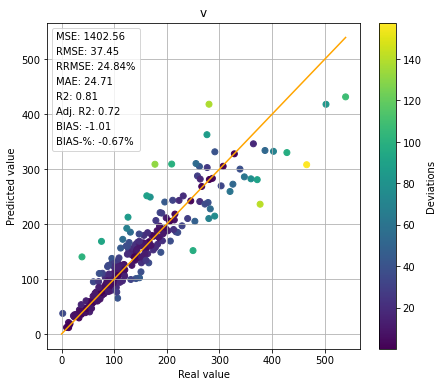

In [88]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys, log_y=False)
plt.show()

Test results

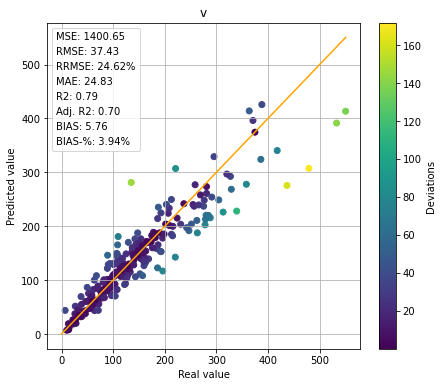

In [89]:
rf_test_preds = rf.predict(test_tb.train.xs)
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()